In [1]:
%matplotlib inline 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random 
import itertools
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [ ]:
import os
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(os.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(os.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = os.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

In [3]:
#we start by converting the dates to timestamp type to extract matches in the desired years 
df_atp["Date"]= pd.to_datetime(df_atp["Date"]) 
df_wta["Date"]= pd.to_datetime(df_wta["Date"]) 

### Who are the three ATP players with the most wins
We use "groupby('Winner').size()" to get the number of won games for each player , then we sort them in the descending order 
so the first 3 elements of the are the first 3 ATP players with the most wins  

In [4]:
winners=df_atp.groupby('Winner').size().sort_values(ascending=False) 

print (winners.index[0] , "is the first ATP player with the most wins by winning ",winners[0] ," matches " )
print (winners.index[1] , "is the second ATP player with the most wins by winning ",winners[1] ," matches " )
print (winners.index[2] , "is the third ATP player with the most wins by winning ",winners[2] ," matches " )


Federer R. is the first ATP player with the most wins by winning  1121  matches 
Nadal R. is the second ATP player with the most wins by winning  891  matches 
Djokovic N. is the third ATP player with the most wins by winning  802  matches 


### How many sets did the player “ Federer R.” win in total ?

In [5]:
#The  number of total sets won by Federer R. is the sum of the sets won in both won and lost matches 
#`1
def won_sets(df):
    #we extract the numbers of won sets in the  won games 
    Wfederer=df[df_atp.Winner=='Federer R.'].Wsets
    #we extract the numbers of won sets in the  lost games 
    Lfederer=df[df_atp.Loser=='Federer R.'].Lsets
    #the one who made the data made a mistake by typing `1 instead of 1 (we check this with the unique() function) 
    # so this will generate an error when using the sum function, we have to correct this mistake 
    for i in Lfederer.index:
        if Lfederer[i] == "`1":
            df.Lsets[i]='1'
            Lfederer[i]='1'
    #we also convert to float type so we can use the sum() function 
    Lfederer=Lfederer.astype('float64')
    # we return 
    return(Lfederer.sum()+Wfederer.sum())
total_Wsets=won_sets(df_atp)
print('Federer R. won in total',int(total_Wsets),'sets')


Federer R. won in total 2696 sets


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?

In [6]:
###### extracting 2016 and 2017 games
partial_df_atp=df_atp[(df_atp["Date"].dt.year==2016) | (df_atp["Date"].dt.year==2017)]
#calulating won sets by Federer R in the years 2016 and 2017
partial_Wsets=won_sets(partial_df_atp)
print('Federer R. won in total',int(partial_Wsets),'sets in 2016 and 2017')

Federer R. won in total 182 sets in 2016 and 2017


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


### For each match, what is the percentage of victories of the winner in the past ?

In [7]:
#for this question will calculate percentage of victories of the winner and also  the loser in the past because
#we'll need both of them later as features
def Pov(df): # WLpov short for  WinnerLoserPercentageOfVictories
    #getting all the players names 
    players=pd.concat((df.Loser,df.Winner)).unique()
    #making a dictionary named players where player={playername:[number of played games , number of won games]}
    #initiliazing the dictionary 
    players_stat=dict.fromkeys(players, np.array([0,0]))
    Wpov=[] #percentage of victory for WINNER in each match, we put nan if it's the players first match
    Lpov=[] #percentage of victory for lOSER in each match, we put nan if it's the players first match
    #if it's the player's first match the value of percentage of victory will be nan 
    for i in range(len(df)):
        if (players_stat[df.Winner[i]][0]==0 and players_stat[df.Loser[i]][0]==0) :
            Wpov.append(np.nan)
            Lpov.append(np.nan)
            #updating the platyers stats
            players_stat[df.Winner[i]]=players_stat[df.Winner[i]]+np.array([1,1])
            players_stat[df.Loser[i]]=players_stat[df.Loser[i]]+np.array([1,0])
            
        elif (players_stat[df.Winner[i]][0]==0 and players_stat[df.Loser[i]][0]!=0) :
            Wpov.append(np.nan)
            Lpov.append('%.2f' % ((players_stat[df.Loser[i]][1]/players_stat[df.Loser[i]][0])*100))
            players_stat[df.Winner[i]]=players_stat[df.Winner[i]]+np.array([1,1])
            players_stat[df.Loser[i]]=players_stat[df.Loser[i]]+np.array([1,0])
            
        elif (players_stat[df.Winner[i]][0]!=0 and players_stat[df.Loser[i]][0]==0) :
            Wpov.append('%.2f' % ((players_stat[df.Winner[i]][1]/players_stat[df.Winner[i]][0])*100))
            Lpov.append(np.nan)
            players_stat[df.Winner[i]]=players_stat[df.Winner[i]]+np.array([1,1])
            players_stat[df.Loser[i]]=players_stat[df.Loser[i]]+np.array([1,0])
            
        else: 
            Wpov.append('%.2f' % ((players_stat[df.Winner[i]][1]/players_stat[df.Winner[i]][0])*100))
            Lpov.append('%.2f' % ((players_stat[df.Loser[i]][1]/players_stat[df.Loser[i]][0])*100))
            players_stat[df.Winner[i]]=players_stat[df.Winner[i]]+np.array([1,1])
            players_stat[df.Loser[i]]=players_stat[df.Loser[i]]+np.array([1,0])
    return pd.DataFrame({'Lpov': Lpov,'Wpov': Wpov})
#the answer for question 4 
Pov(df_atp).Wpov
Pov(df_wta).Wpov

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16       100.00
17       100.00
18       100.00
19       100.00
20       100.00
21       100.00
22       100.00
23       100.00
24       100.00
25       100.00
26       100.00
27       100.00
28       100.00
29       100.00
          ...  
29551     64.09
29552     64.64
29553     60.44
29554     52.40
29555     70.98
29556     64.20
29557     64.19
29558     60.57
29559     64.57
29560     64.31
29561     52.38
29562     60.69
29563     64.41
29564     60.82
29565     64.52
29566     67.11
29567     63.87
29568     60.67
29569     52.38
29570     61.96
29571     63.38
29572     60.80
29573     55.31
29574     56.49
29575     56.60
29576     63.49
29577     51.39
29578     61.11
29579     51.72
29580     61.42
Name: Wpov, Length: 2958

### Cleaning the data & feature engineering 
In this section we will get rid of unnecessary data as well as creating new features 

In [8]:
#we start by adding a new feature : the pov for the winner and the loser
df_atp=pd.concat((df_atp,Pov(df_atp)),axis=1)
df_wta=pd.concat((df_wta,Pov(df_wta)),axis=1)
#we will only  use data from the year 2006 till the year 2017
df_atp=df_atp[(df_atp["Date"].dt.year>=2006)  & (df_atp["Date"].dt.year<=2017)]
df_wta=df_wta[(df_wta["Date"].dt.year>=2006) &  (df_wta["Date"].dt.year<=2017)]
# we use only the completed matches 
df_atp=df_atp[(df_atp["Comment"]=='Completed')]
df_wta=df_wta[(df_wta["Comment"]=='Completed')]
#let's drop unnecessary data 
df_atp.drop(["Comment",'ATP',"Best of","Location","Round","Series","Tournament",'Surface'],axis=1, inplace=True)
df_wta.drop(["Comment","Best of","Location","Round","Tournament","WTA","Tier",'Surface'],axis=1, inplace=True)
#let's check the  missing data , this function return the percentage of NaN values for each columns 
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("atp_atp dataframe")
print(missing_data(df_atp))
print("atp_wta dataframe")
print(missing_data(df_wta))


atp_atp dataframe
        Total     Percent
SBL     30941  100.000000
SBW     30941  100.000000
GBW     30941  100.000000
GBL     30941  100.000000
IWL     30941  100.000000
IWW     30941  100.000000
B&WL    30941  100.000000
B&WW    30941  100.000000
W5      29856   96.493326
L5      29856   96.493326
L4      28122   90.889112
W4      28122   90.889112
CBW     25786   83.339259
CBL     25786   83.339259
UBW     20688   66.862739
UBL     20688   66.862739
W3      16243   52.496687
L3      16243   52.496687
SJW     16021   51.779193
SJL     16014   51.756569
AvgW    11637   37.610291
MaxW    11637   37.610291
MaxL    11637   37.610291
AvgL    11637   37.610291
LBW      6028   19.482240
LBL      6017   19.446689
PSL      2898    9.366213
PSW      2898    9.366213
EXW       752    2.430432
EXL       747    2.414272
Lpov      535    1.729097
B365W     350    1.131185
B365L     330    1.066546
Wpov      162    0.523577
LRank      62    0.200381
LPts       62    0.200381
WRank      11    0.0

In [9]:
# now let's get  rid of columns that has more than 5% of NaN values
def clean_nan(df):
    to_keep=[]
    for i in df.columns:
        if (df[i].isna().sum()/len(df[i]))<0.05 :
            to_keep.append(i)
    return df[to_keep]

df_atp=clean_nan(df_atp)
df_wta=clean_nan(df_wta)
#odering the columns of df_wta dataframe
df_wta=df_wta[df_atp.columns.tolist()]
#there still some missing data ,so let's impute it 
df_atp=df_atp.fillna(0)
df_wta=df_wta.fillna(0)
#let's do labelencoding for the court feature 
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
df_atp.Court = labelencoder_y.fit_transform(df_atp.Court)
df_wta.Court = labelencoder_y.fit_transform(df_wta.Court)

In [10]:
#this function will create new feature which is the percentage of won 'chosen feature' in the past for both the winner
#and loser 

def WLpov(df,columns): # WLpov short for  WinnerLoserPercentageOfVictory ,the  parameter 'columns' is  for which features we want
    #to calculate the pov
    
    #getting all the players names 
    players=pd.concat((df.Loser,df.Winner)).unique()
    
    #making a dictionary named players where players={playername:[percentage of won 'feature ' , number of played games]}
    #initiliazing the dictionary 
    players_stat=dict.fromkeys(players, np.array([0,1]))
   
    Wpov=[] #percentage of victory for WINNER in each match, we put 0 if it's the players first match
    Lpov=[] #percentage of victory for lOSER in each match, we put 0 if it's the players first match
    #if it's the player's first match the value of percentage of victory will be 0
    for i in range(len(df)):
        #we statrt by appending pov of last match 
        Wpov.append(players_stat[df.Winner[i]][0])
        Lpov.append(players_stat[df.Loser[i]][0])
       
        #calculating the total number of played 'feature '
        total=df[columns[0]][i]+df[columns[1]][i]
       
        #there's case where the features are 0 so we won't updating anything in this case 
        if total==0:
            continue
            
        k=players_stat[df.Loser[i]][1] #getting the number of played games for the loser
        l=players_stat[df.Winner[i]][1]#getting the percentage of won 'feature ' for the loser
       
        
        statL=players_stat[df.Loser[i]][0] #getting the number of played games for the winner
        matchL=players_stat[df.Loser[i]][1]#getting the percentage of won 'feature ' for the Winner
        
        #making a copy to use in updating the the percentage of won 'feature '
        statW=players_stat[df.Winner[i]][0]
        matchW=players_stat[df.Winner[i]][1]
       
        #updating the pov for winner and loser  
        players_stat[df.Loser[i]]=np.array([k*statL/(k+1),matchL])+np.array([((df[columns[0]][i])/total)/(k+1),0])
        players_stat[df.Winner[i]]=np.array([l*statW/(l+1),matchW])+np.array([((df[columns[1]][i])/total)/(l+1),0])
       
        #updating the number of played games 
        players_stat[df.Loser[i]]+=np.array([0,1])
        players_stat[df.Winner[i]]+=np.array([0,1]) 
        
    return pd.DataFrame({columns[0]+'pov': Lpov,columns[1]+'pov': Wpov})



In [11]:
#creating a list of features  and converting them to float in order to extract the percentage of won 'feature' in the past 
columns=['L1','L2','Lsets','W1','W2','Wsets']
for i in columns:
    df_atp[i]= df_atp[i].astype(float)
    df_wta[i]= df_wta[i].astype(float)
#resetting the index
df_atp=df_atp.reset_index(drop=True)
df_wta=df_wta.reset_index(drop=True)
#appending the new featurs to our dataframes
for i in range(3):
    df_atp=pd.concat((df_atp,WLpov(df_atp,[columns[i],columns[i+3]])),axis=1)
    df_wta=pd.concat((df_wta,WLpov(df_wta,[columns[i],columns[i+3]])),axis=1)
#dropping old features     
df_atp.drop(columns,axis=1,inplace=True)
df_wta.drop(columns,axis=1,inplace=True)
#creating a new feature 'sex' since we have male and female players
df_atp['sex']=[0 for i in range(len(df_atp))]
df_wta['sex']=[1 for i in range(len(df_wta))]
#let's rearrange our columns 
columns=["Date","Court","sex","B365L","EXL","LPts","LRank","Lpov","L1pov","L2pov","Lsetspov","Loser"
         ,"B365W","EXW","WPts","WRank",'Wpov','W1pov','W2pov','Wsetspov',"Winner"]
df_atp=df_atp[columns]
df_wta=df_wta[columns]
#now let's concatenate the df_atp and df_wta dataframes and get our clean data 
clean_data=pd.concat((df_atp,df_wta),axis=0,ignore_index=True )
clean_data.head()



,Date,Court,sex,B365L,EXL,LPts,LRank,Lpov,L1pov,L2pov,...,Loser,B365W,EXW,WPts,WRank,Wpov,W1pov,W2pov,Wsetspov,Winner
0,2006-01-02,1,0,2.75,3.10,692.0,51.0,53.33,0.0,0.0,...,Calleri A.,1.39,1.35,1200.0,24.0,51.76,0.0,0.0,0.0,Berdych T.
1,2006-01-02,1,0,2.37,2.25,265.0,156.0,50.00,0.0,0.0,...,Guccione C.,1.53,1.6,470.0,86.0,32.20,0.0,0.0,0.0,Kohlschreiber P.
2,2006-01-02,1,0,3.25,3.35,286.0,146.0,35.29,0.0,0.0,...,Luczak P.,1.28,1.3,731.0,47.0,53.39,0.0,0.0,0.0,Malisse X.
3,2006-01-02,1,0,2.37,2.50,690.0,52.0,48.34,0.0,0.0,...,Melzer J.,1.53,1.5,1490.0,19.0,60.84,0.0,0.0,0.0,Robredo T.
4,2006-01-02,1,0,2.62,2.75,558.0,69.0,54.14,0.0,0.0,...,Clement A.,1.44,1.42,1360.0,21.0,54.97,0.0,0.0,0.0,Ancic M.


##### Features to use for the models and creating the labels 

In the data, the features were labeled  for the winner and loser, so for each match we will  randomly
assigned “Player 1” to be either the winner or loser, and “Player 2” to be the other person.

The features we will train on will all be differences between features of player 1 and player 2 . This was
done to achieve symmetry. We want a model where the labeling of the players as Player 1 or Player 2 doesn’t matter in fact 
the label will be 1 if player 1 won and 0 if he lost .

So we'll implement a function named create_final_data that will generate the symetric features as well as the lables at the same 
time.


In [12]:
#we are going to use the  function  that generates the featueres and labels but it gives an error and by debugging i found that 
#the one who made the data made another mistake again by typing 2.,3 instead of 2.3 and 5..5 instead of 5.5
#so we have correct this mistake 
clean_data['EXW'][20028]=2.3
clean_data['B365L'][33020]=5.5


def create_final_data(df):
    label=[] #initializing the list of the labels
    feature_names=["B365","EX","Pts","Rank",'pov','1pov','2pov','setspov'] # a list of the symetric features 
    #initializing the list of symetric features
    feature=np.array([0 for i in range(len(feature_names))])
    for i in range(len(df)):
        
        #extracting the features of the Loser
        L=np.array(df.iloc[i,3:11].values,dtype=np.float)
        #extracting the features of the winner
        W=np.array(df.iloc[i,12:20].values,dtype=np.float) 
        #generating a random number a 
        permutaion =random.randint(0, 1)
# we'll consider that the loser is player 1 and winner player 2 , we'll generate a number named permutaion  
#if a=1 we ermute the winner and the loser places and the new feature will be featurewinner - feature loser and the label will be 1
#if a=0 no permutation and the new feature will be feature loser - feature winner and the label will be 0
        if permutaion==0:
            label.append(0)
            feature=np.vstack((feature,L-W))
        else:
            label.append(1)
            feature=np.vstack((feature,W-L))
    #let's delete the first line created in the initialization  in order to append the features
    feature = np.delete(feature, (0), axis=0)
    #let's drop the old features 
    df.drop(df.columns[3:],axis=1,inplace=True)
    #let's append the new feature tothe dataframe
    k=0
    for i in  feature_names:
        df[i]=feature[:,k]
        k+=1
    # appending labels
    df['label']=label
    
    return df
final_data=create_final_data(clean_data)
final_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Date,Court,sex,B365,EX,Pts,Rank,pov,1pov,2pov,setspov,label
0,2006-01-02,1,0,-1.36,-1.75,508.0,-27.0,-1.57,0.0,0.0,0.0,1
1,2006-01-02,1,0,0.84,0.65,-205.0,70.0,17.80,0.0,0.0,0.0,0
2,2006-01-02,1,0,-1.97,-2.05,445.0,-99.0,18.10,0.0,0.0,0.0,1
3,2006-01-02,1,0,0.84,1.00,-800.0,33.0,-12.50,0.0,0.0,0.0,0
4,2006-01-02,1,0,1.18,1.33,-802.0,48.0,-0.83,0.0,0.0,0.0,0


In [162]:
#let's create the train and test sets
train=final_data[(final_data["Date"].dt.year!=2017) ]
test=final_data[(final_data["Date"].dt.year==2017) ]
X_train,y_train=train.iloc[:,1:11].values,train.iloc[:,11].values
X_test, y_test=test.iloc[:,1:11].values,test.iloc[:,11].values

### Creating the models and evaluating them 

In [163]:
# a function to plot the confusion matrix 
def plot_confusion_matrix(cm,
                          target_names,
                          model,
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    model:        the name of the model 

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions


     """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title="Confusion matrix of "+model+" model"
   
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.xlabel('predicted label \n accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.ylabel('True Label')
    plt.show()

### SVM Model

In [ ]:
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score,confusion_matrix,roc_curve,auc
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf' , random_state = 0)#,probability=True)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#we won't plot the 

# probs = classifier.predict_proba(X_test)
# preds = probs[:,1]
# fprsvm, tprsvm, _ = roc_curve(y_test, preds)
# roc_auc_svm = auc(fprsvm, tprsvm)
print('The accuracy for the SVM model is %0.2f' % (accuracy_score(y_test, y_pred)) )
print('The precision  for the SVM model is %0.2f' % (precision_score(y_test, y_pred)))
print('The recall for the SVM model is %0.2f' % (recall_score(y_test, y_pred)))
print('The f1_score for the SVM model is %0.2f' % (f1_score(y_test, y_pred)))
plot_confusion_matrix(cm,[0,1],"SVM")


### Logistic regression model 

The accuracy for the Logistic Regression model is 0.67
The precision  for the Logistic Regression model is 0.68
The recall for the Logistic Regression model is 0.67
The f1_score for the Logistic Regression model is 0.68


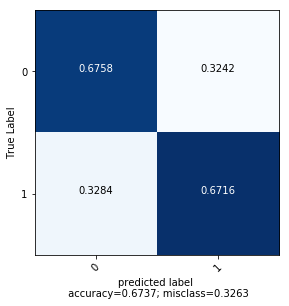

In [153]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fprlr, tprlr, _ = roc_curve(y_test, preds)
roc_auc_lr = auc(fprlr,tprlr)
print('The accuracy for the Logistic Regression model is %0.2f' % (accuracy_score(y_test, y_pred)) )
print('The precision  for the Logistic Regression model is %0.2f' % (precision_score(y_test, y_pred)))
print('The recall for the Logistic Regression model is %0.2f' % (recall_score(y_test, y_pred)))
print('The f1_score for the Logistic Regression model is %0.2f' % (f1_score(y_test, y_pred)))
plot_confusion_matrix(cm,[0,1],"Logistic Regression")



### Random forest model 

The accuracy for the Random forest model is 0.65
The precision  for the Random forest model is 0.67
The recall for the Random forest model is 0.59
The f1_score for the Random forest model is 0.63


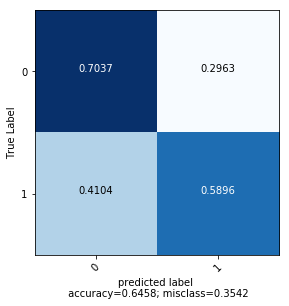

In [154]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fprrf, tprrf, _ = roc_curve(y_test, preds)
roc_auc_rf = auc(fprrf,tprrf)
print('The accuracy for the Random forest model is %0.2f' % (accuracy_score(y_test, y_pred)) )
print('The precision  for the Random forest model is %0.2f' % (precision_score(y_test, y_pred)))
print('The recall for the Random forest model is %0.2f' % (recall_score(y_test, y_pred)))
print('The f1_score for the Random forest model is %0.2f' % (f1_score(y_test, y_pred)))
plot_confusion_matrix(cm,[0,1],"Random forest")



### ANN Model

In [155]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.metrics import confusion_matrix,roc_curve,auc

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units =50,  activation = 'relu', input_dim =10))


# # Adding the  hidden layer
classifier.add(Dense(units = 20, activation = 'relu'))
classifier.add(Dense(units =50 , activation = 'relu'))

classifier.add(Dense(units = 30, activation = 'relu'))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 1000, epochs = 100)
y_pred = classifier.predict(X_test)
y_pred =(y_pred>0.5)

probs = classifier.predict_proba(X_test)
preds = probs[:,0]
fprann, tprann, _ = roc_curve(y_test, preds)
roc_auc_ann= auc(fprann,tprann)
print('The accuracy for the ann model is %0.2f' % (accuracy_score(y_test, y_pred)) )
print('The precision  for the ann model is %0.2f' % (precision_score(y_test, y_pred)))
print('The recall for the ann model is %0.2f' % (recall_score(y_test, y_pred)))
print('The f1_score for the ann model is %0.2f' % (f1_score(y_test, y_pred)))
plot_confusion_matrix(cm,[0,1],"ANN")




Epoch 1/100
52126/52126 [==============================] - 5s 96us/step - loss: 0.6097 - acc: 0.6708
Epoch 2/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5667 - acc: 0.7031
Epoch 3/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5622 - acc: 0.7073
Epoch 4/100
52126/52126 [==============================] - 1s 11us/step - loss: 0.5612 - acc: 0.7071
Epoch 5/100
52126/52126 [==============================] - 1s 12us/step - loss: 0.5610 - acc: 0.7071
Epoch 6/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5602 - acc: 0.7081
Epoch 7/100
52126/52126 [==============================] - 1s 12us/step - loss: 0.5601 - acc: 0.7077
Epoch 8/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5602 - acc: 0.7077
Epoch 9/100
52126/52126 [==============================] - 1s 11us/step - loss: 0.5594 - acc: 0.7087
Epoch 10/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5594 - a

52126/52126 [==============================] - 1s 14us/step - loss: 0.5506 - acc: 0.7143
Epoch 81/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5499 - acc: 0.7131
Epoch 82/100
52126/52126 [==============================] - 1s 11us/step - loss: 0.5498 - acc: 0.7151
Epoch 83/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5502 - acc: 0.7148
Epoch 84/100
52126/52126 [==============================] - 1s 12us/step - loss: 0.5494 - acc: 0.7157
Epoch 85/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5494 - acc: 0.7145
Epoch 86/100
52126/52126 [==============================] - 1s 12us/step - loss: 0.5495 - acc: 0.7153
Epoch 87/100
52126/52126 [==============================] - 1s 13us/step - loss: 0.5492 - acc: 0.7150
Epoch 88/100
52126/52126 [==============================] - 1s 12us/step - loss: 0.5498 - acc: 0.7141
Epoch 89/100
52126/52126 [==============================] - 1s 11us/step - loss: 0.5492 - acc: 

IndexError: index 1 is out of bounds for axis 1 with size 1

### XGBOOST 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy for the XGBOOST model is 0.68
The precision  for the XGBOOST model is 0.70
The recall for the XGBOOST model is 0.64
The f1_score for the XGBOOST model is 0.67


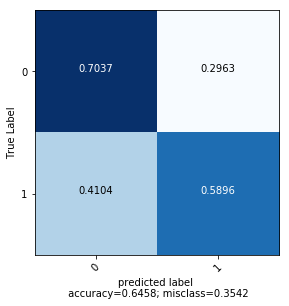

In [157]:
from xgboost import  XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
model.predict(X_test)
probs = model.predict_proba(X_test)
preds = probs[:,1]
fprXGBOOST, tprXGBOOST, _ = roc_curve(y_test, preds)
roc_auc_XGBOOST = auc(fprann,tprann)
print('The accuracy for the XGBOOST model is %0.2f' % (accuracy_score(y_test, y_pred)) )
print('The precision  for the XGBOOST model is %0.2f' % (precision_score(y_test, y_pred)))
print('The recall for the XGBOOST model is %0.2f' % (recall_score(y_test, y_pred)))
print('The f1_score for the XGBOOST model is %0.2f' % (f1_score(y_test, y_pred)))
plot_confusion_matrix(cm,[0,1],"XGBOOST")

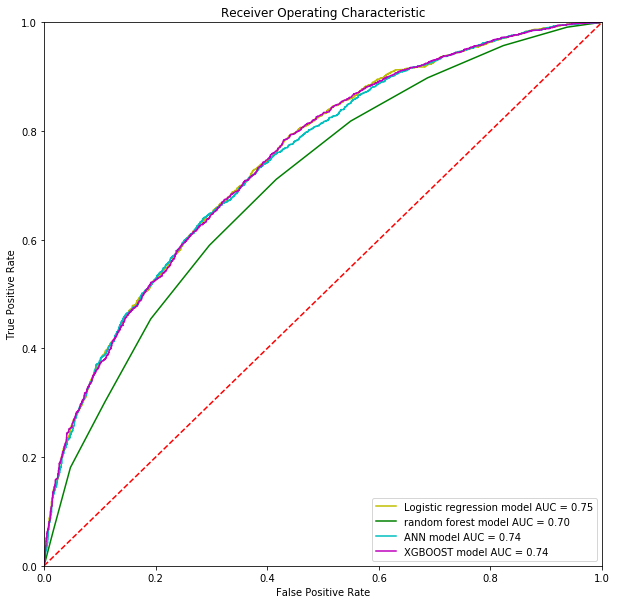

In [159]:
plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
# plt.plot(fprsvm, tprsvm, 'b', label = 'SVM Model AUC = %0.2f' % roc_auc_svm)
plt.plot(fprlr, tprlr, 'y', label = 'Logistic regression model AUC = %0.2f' % roc_auc_lr)
plt.plot(fprrf, tprrf, 'g', label = 'random forest model AUC = %0.2f' % roc_auc_rf)
plt.plot(fprann, tprann, 'c', label = 'ANN model AUC = %0.2f' % roc_auc_ann)
plt.plot(fprXGBOOST, tprXGBOOST, 'm', label = 'XGBOOST model AUC = %0.2f' % roc_auc_XGBOOST)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()